# Classical regression model with bayesian inference

The equation of the classic linear regression is 

$
y_i = X_i^\top\beta + \epsilon_i, \; \epsilon_i \sim N(0,\sigma^2).
$

where $\beta$ is a vector of parameters to be estimated, $X_i$ is the i-th row of $X$ and $\epsilon_i$ is the i-th error with Normal distribution. We can estimate the vector of parameters with classical inference maximizing the log-likelihood function or we can use bayesian inference. In bayesian inference we have that the parameters are not fixed, not in frequentist statistic, it´s mean that they have some distribution. 





For a better explanation, lets see the bayes theorem 
$
P(A|B) \propto P(B|A) P(A),
$
where $P(B|A)$ represents the support B provides for A, in other words, the likelihood of our model, $P(A)$, the prior, is the initial degree of belief in A and $P(A|B)$, the posterior, is the degree of belief after incorporating news that B is true. 


Now, in our regression model, the likelihood are obtained by some operations

$
L(\beta,\sigma^2,y)=\prod_{i=1}^n\dfrac{1}{\sqrt{2\pi}}\dfrac{1}{\sigma}e^{1/2\left(\dfrac{y_i-x_i^T\beta}{\sigma}\right)^2},
$
where $L(\beta,\sigma^2,y)$ represents the likelihood of our model considering parameters.
Next, we have to define the prior distribution, because we don´t have prior information of the behavier of the parameters, lets define a noninformative prior distribution by $p(\beta,\sigma^2)\propto \frac{1}{\sigma^2},$

next, the posterior distribution is obtained by the multiplication of the likelihood and the prior distribution of the parameters by

$
p(\beta,\sigma^2|Y)\propto L(\beta,\sigma^2,y) p(\beta,\sigma^2),
$

before some operation we obtain 

$
p(\beta,\sigma^2|Y)\propto \dfrac{1}{\sigma^{2(0.5n+1)}}\prod_{i=1}^n e^{\left(\dfrac{y_i-x_i^T\beta}{2\sigma^2}\right)^2}.
$

We can use some algorithm to genarate random samples of this multivariate distribution like the Gibbs sampling algorithm. The algorithm consists in obtain the full conditional distributions and next obtain random samples

$\beta|\sigma^2,Y\sim Normal(U_\beta,\Sigma_\beta)$

,with
$\Sigma_\beta=[\frac{X^TX}{\sigma^2}]^{-1}
$, 
$U_\beta=\Sigma_\beta^{-1}[\frac{X^TY}{\sigma^2}]^{-1}
$,

$
\sigma^2|\beta,y\sim InverseGamma(\frac{n}{2},\frac{\Sigma_{i=1}^n(y_i-x_i^T\beta)^2}{2})
$.

The Gibbs sampling algorithm consists in


* Generate $\beta^{k+1}$ from $h(\beta|y,{\sigma^2}^k)$

* Generate ${\sigma^2}^{k+1}$ from $h(\sigma^2|y,\beta^{k+1})$.





# The implementation

Using R and the MASS library we can implement our regression model. The *lm_normal* function needs three inputs: 

* y: is the response variable in the regression model
* x: is a set of explanatory variables 
* steps: is the value of samples to generate

In [1]:
lm_normal = function(y,x,steps = 5000){
  require(MASS)
  X<-as.matrix(cbind.data.frame(1,x))
  numberOfCovariates = dim(X)[2]
  n = dim(X)[1]
  
  ## Declaring the parameters of the model
  Beta = matrix(0,steps,numberOfCovariates)
  colnames(Beta) = c(paste("Beta_",0:(numberOfCovariates-1),sep=""))
  sigma2 = numeric()
  
  ## Inicial values
  Beta[1,] <- 10
  sigma2[1] <- var(y)
  
  for(step_i in 2:steps){
    mu = Beta[step_i-1,]%*%t(X)
    Mv <- solve(t(X)%*%X)*sigma2[step_i-1]
    mu.beta = solve(t(X)%*%X)%*%t(X)%*%y
    b <- mvrnorm(1,mu.beta,Sigma = Mv)
    Beta[step_i,] <- b
    
    mu = Beta[step_i-1,]%*%t(X)
    a.sigma = 0.5*n
    b.sigma = 0.5*sum((y-mu)**2)
    sigma2[step_i] = 1/rgamma(1,a.sigma,b.sigma)
  }
  return(list(Beta = Beta, sigma2 = sigma2))
}


# Student-t regression with bayesian inference
Now considering errors with Student-t distribution

$
y_i=x_i^T\beta + \epsilon_i, \; \epsilon_i\sim t(0,\sigma^2,v)
$

where $v$ is the degree of freedom of the Student-t distribution. 

Using the propertie of the Student-t distribution, the  equation above can be expressed:
$
y_i|\beta,z\sim N(x_i^T\beta,\frac{\sigma^2}{z})
\; 
z\sim Gamma(\frac{v}{2}, \frac{v}{2}).
$

Considering a sample size $n$, the $z_i$ as latent variables and the degree of freedom, $v (v>2)$, fixed, so the likelihood with the latent component is given as:

$
L(\beta,\sigma^2,Z,y)=\prod_{i=1}^n\dfrac{1}{\sqrt{2\pi}}\dfrac{z_i^{1/2}}{\sigma}e^{1/2\left(\dfrac{y_i-x_i^T\beta}{\sigma}\right)^2z_i}\dfrac{v/2^{(v/2)}}{\Gamma(v/2)}z_i^{v/2-1}e^{-v/2z_i}
$.

The posterior distribution is given as:

$
p(\beta,\sigma^2,Z|Y)\propto \dfrac{1}{\sigma^{2(0.5n+1)}}\prod_{i=1}^n z_i^{1/2}e^{(\dfrac{y_i-x_i^T\beta}{2\sigma^2})^2z_i}z_i^{v/2}e^{-vz_i/2}
$

To simulate the posterior distribution Gibbs sampling is used, so it is obtained the full conditional distributions:

$z_i|y_i,\beta,\sigma^2\sim Gamma(\frac{v+1}{2},\frac{1}{2}\left(v+\frac{(y_i-x_i^T\beta)^2}{\sigma^2}\right))$

$\beta|Z,\sigma^2,Y\sim Normal(U_\beta,\Sigma_\beta)$
,with
$\Sigma_\beta=[\frac{X^TZX}{\sigma^2}]^{-1}
$, 
$U_\beta=\Sigma_\beta^{-1}[\frac{X^TZY}{\sigma^2}]^{-1}
$

$
\sigma^2|Z,\beta,y\sim InverseGamma(\frac{n}{2},\frac{\Sigma_{i=1}^n(y_i-x_i^T\beta)^2}{2}z_i)
$

The gibbs sampling algorithm consists in

* Generate from $z_i^{k+1}$ for $i=1,...,n.$

* Generate $\beta^{k+1}$ from $h(\beta|y,Z^{k+1},{\sigma^2}^k)$

* Generate ${\sigma^2}^{k+1}$ from $h(\sigma^2|y,Z^{k+1},\beta^{k+1})$



# The implementation
Using R and the MASS library we can implement our regression model. The *lm_t* function needs four inputs: 

* y: is the response variable in the regression model
* x: is a set of explanatory variables 
* v: is the degree of freedom
* steps: is the value of samples to generate

In [2]:
lm_t = function(y,x,v,steps = 5000){
  require(MASS)
  X<-as.matrix(cbind.data.frame(1,x))
  numberOfCovariates = dim(X)[2]
  n = dim(X)[1]
  
  ## Declaring the parameters of the model
  Beta = matrix(0,steps,numberOfCovariates)
  colnames(Beta) = c(paste("Beta_",0:(numberOfCovariates-1),sep=""))
  sigma2 = numeric()
  
  ## Inicial values
  Beta[1,] <- 10
  sigma2[1] <- var(y)
  
  for(step_i in 2:steps){
    mu = Beta[step_i-1,]%*%t(X)
    w1 <- rgamma(n,(v+1)/2,(v+(y-mu)^2/sigma2[step_i-1])/2)
    w <- diag(w1)
    
    Mv <- solve(t(X)%*%w%*%X)*sigma2[step_i-1]
    mu.beta = solve(t(X)%*%w%*%X)%*%t(X)%*%w%*%y
    b <- mvrnorm(1,mu.beta,Sigma = Mv)
    Beta[step_i,] <- b
    
    mu = Beta[step_i-1,]%*%t(X)
    a.sigma = 0.5*n
    b.sigma = 0.5*sum((y-mu)**2*w1)
    sigma2[step_i] = 1/rgamma(1,a.sigma,b.sigma)
  }
 return(list(Beta = Beta, sigma2 = sigma2))
   }

# Application

In this section, we compare the Student-t linear regression model with the classic regression one. For a better vizualization, is considered one explanatory variable. The house prices advanced regression techniques competition is about to predict the sale price of houses in Ames and Iowa. We are considering only the GrLivArea to see the equation estimated, but this model can support multiple explanatory variables.

In [3]:
library(dplyr)
library(ggplot2)
library(Metrics)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




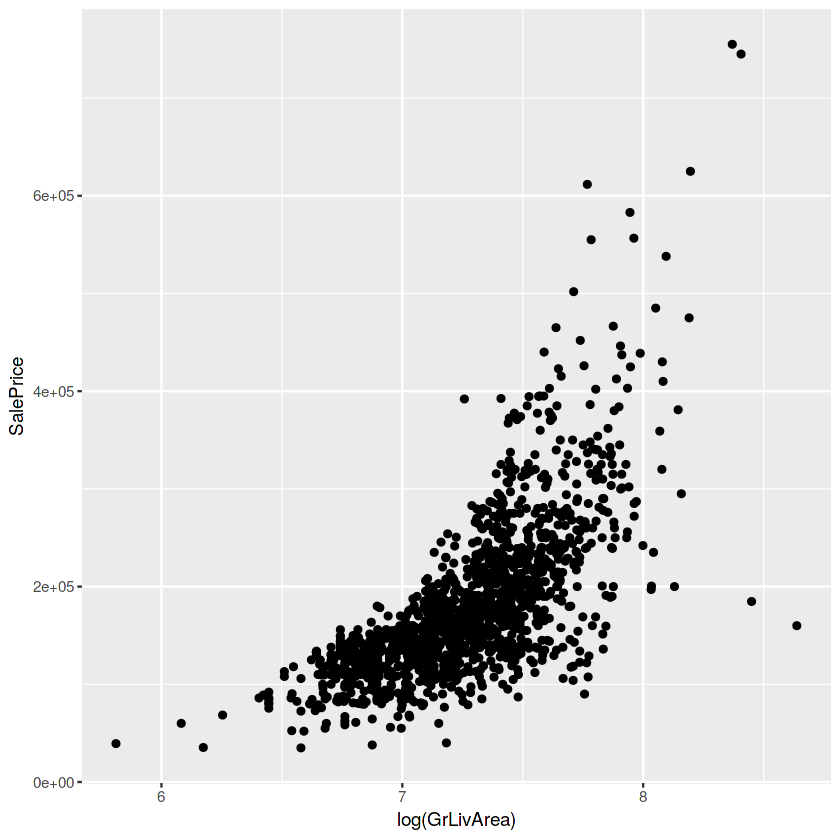

In [4]:
dataIncial = read.csv("../input/house-prices-advanced-regression-techniques/train.csv")
ggplot(dataIncial) + 
       geom_point(aes(log(GrLivArea),SalePrice))


Taking the 80% of the data to train and the 20% to validate our models.

In [5]:
dataIncial %>% dplyr::select(Id,GrLivArea,SalePrice) %>% sample_frac(0.8) -> train

dataIncial %>% dplyr::anti_join(train, by = 'Id') %>%  dplyr::select(Id,GrLivArea,SalePrice) -> validation


We are considering a linear and polynomial of degree 2 regression, this is

$
SalePrice_i = \beta_0 + log(GrLivArea_i)\beta_1 + \epsilon_i,
$


$
SalePrice_i = \beta_0 + log(GrLivArea_i)\beta_1 + log(GrLivArea_i)^2\beta_1  + \epsilon_i,
$

where, $\epsilon_i$ can assume Normal or Student-t distribution.

In [6]:

model1 = lm_normal(y = train$SalePrice,x = log(train$GrLivArea),steps = 5000)
model2 = lm_t(y = train$SalePrice,x = log(train$GrLivArea),v = 3,steps = 5000)

modelq1 = lm_normal(y = train$SalePrice,x = poly(log(train$GrLivArea),2,raw = TRUE),steps = 5000)
modelq2 = lm_t(y = train$SalePrice,x = poly(log(train$GrLivArea),2,raw = TRUE),v = 3,steps = 5000)

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




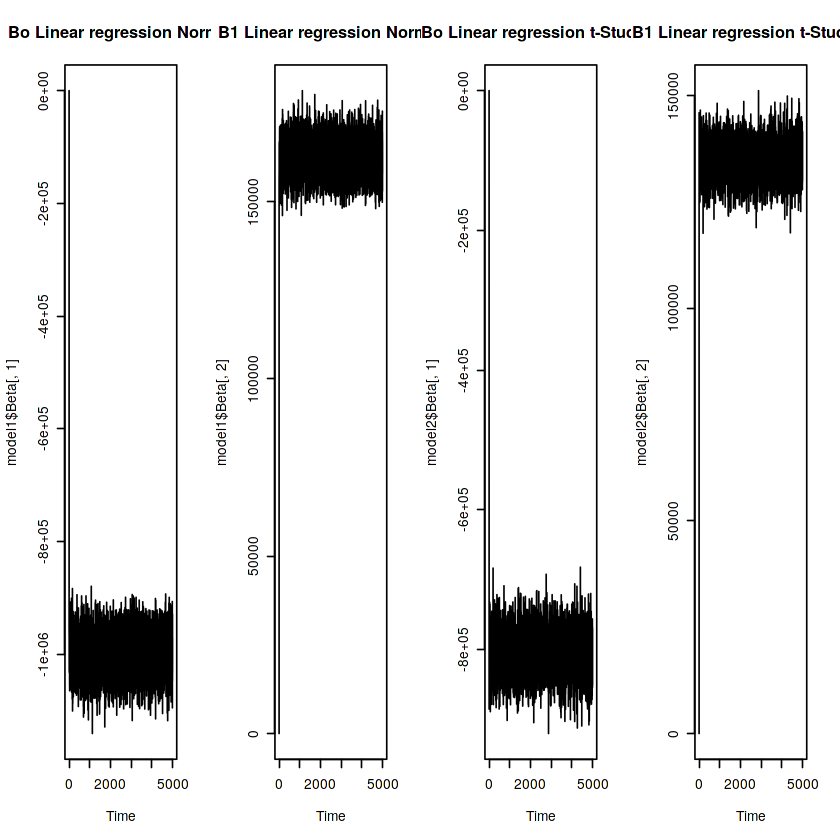

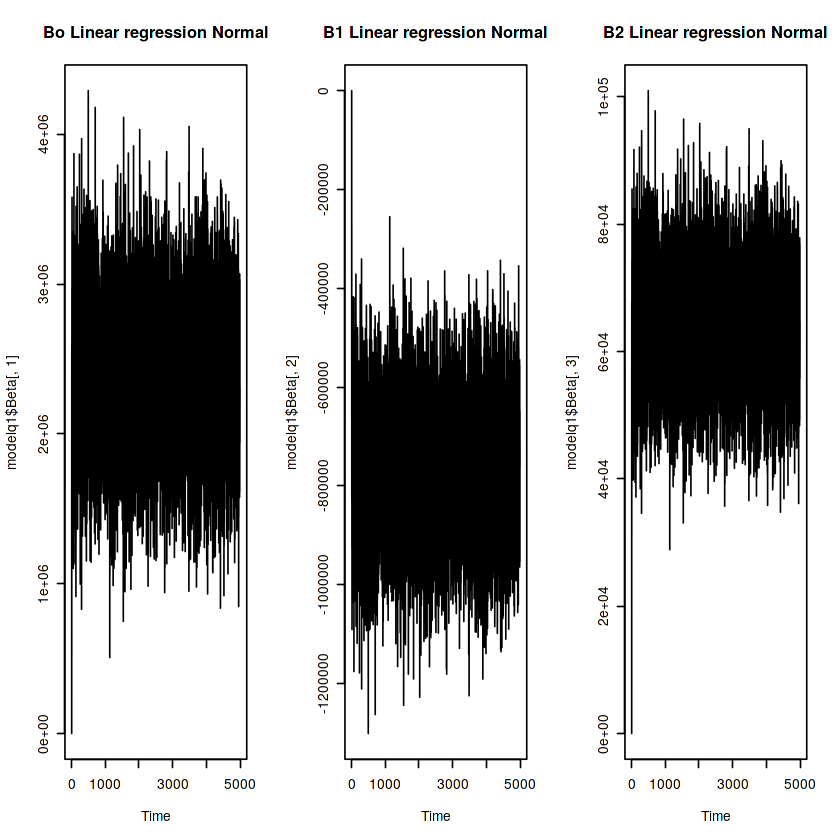

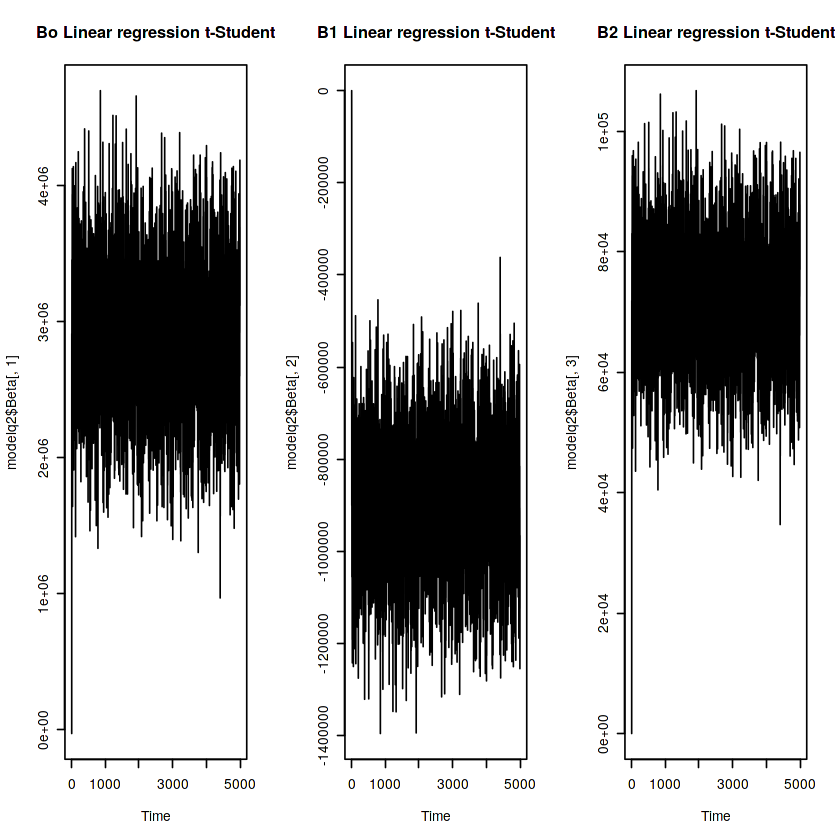

In [7]:
par(mfrow=c(1,4))
ts.plot(model1$Beta[,1],main="Bo Linear regression Normal")
ts.plot(model1$Beta[,2],main="B1 Linear regression Normal")
ts.plot(model2$Beta[,1],main="Bo Linear regression t-Student")
ts.plot(model2$Beta[,2],main="B1 Linear regression t-Student")

par(mfrow=c(1,3))
ts.plot(modelq1$Beta[,1],main="Bo Linear regression Normal")
ts.plot(modelq1$Beta[,2],main="B1 Linear regression Normal")
ts.plot(modelq1$Beta[,3],main="B2 Linear regression Normal")


par(mfrow=c(1,3))
ts.plot(modelq2$Beta[,1],main="Bo Linear regression t-Student")
ts.plot(modelq2$Beta[,2],main="B1 Linear regression t-Student")
ts.plot(modelq2$Beta[,3],main="B2 Linear regression t-Student")


The Gibss sampling algorithm converge from all regression models. Now we can make predictions in the validation set and evaluate. 

In [8]:
x = log(validation$GrLivArea)

val_predictionNormal = colMeans(model1$Beta)%*%t(as.matrix(cbind.data.frame(1,x)))
print(paste("The MSLE for the normal linear regression model is : ",
            msle(actual = validation$SalePrice,val_predictionNormal)) )
val_predictionTstudent = colMeans(model2$Beta)%*%t(as.matrix(cbind.data.frame(1,x)))
print(paste("The MSLE for the t-Student linear regression model is : ",
            msle(actual = validation$SalePrice,val_predictionTstudent)) )

#############################################
x = poly(log(validation$GrLivArea),2,raw = TRUE)

val_predictionNormalPoly = colMeans(modelq1$Beta)%*%t(as.matrix(cbind.data.frame(1,x)))
print(paste("The MSLE for the polinomial Normal regression model is : ",
            msle(actual = validation$SalePrice,val_predictionNormalPoly)) )
val_predictionTstudentPoly = colMeans(modelq2$Beta)%*%t(as.matrix(cbind.data.frame(1,x)))
print(paste("The MSLE for the polinomial t-Student regression model is : ",
            msle(actual = validation$SalePrice,val_predictionTstudentPoly)) )


[1] "The MSLE for the normal linear regression model is :  0.0985435622727415"
[1] "The MSLE for the t-Student linear regression model is :  0.0769893553214811"
[1] "The MSLE for the polinomial Normal regression model is :  0.0760502767882088"
[1] "The MSLE for the polinomial t-Student regression model is :  0.077215841373649"


So the best model is the polinomial regression with degree 2 and Student-t errors.


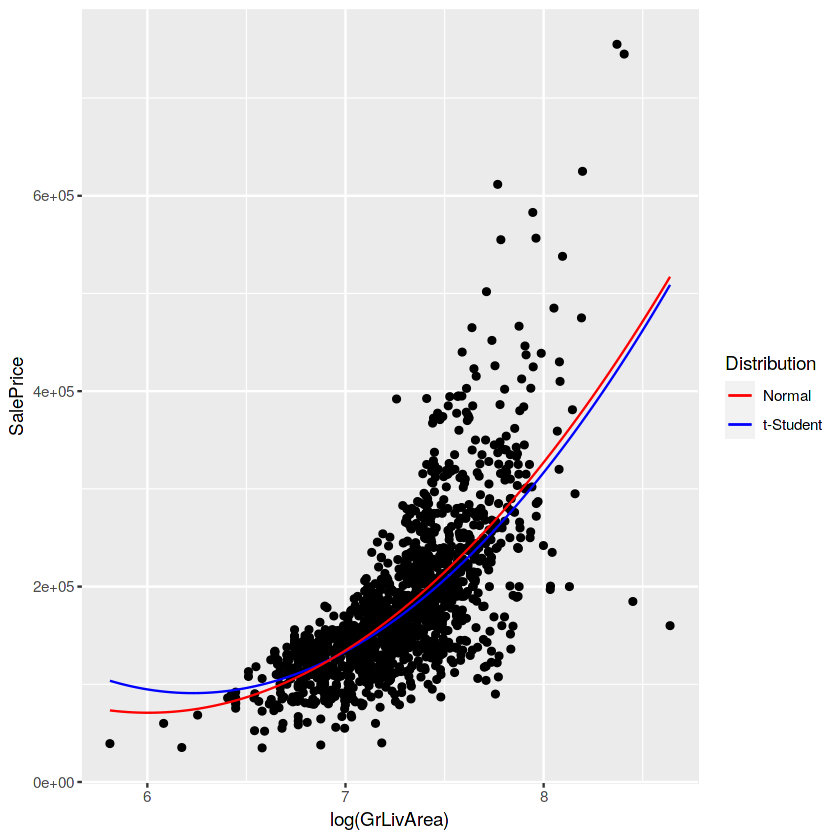

In [9]:
ggplot(dataIncial) + 
       geom_point(aes(log(GrLivArea),SalePrice)) +

  stat_function(fun=function(x) mean(modelq2$Beta[,1]) 
      +mean(modelq2$Beta[,2])*x
      +mean(modelq2$Beta[,3])*x^2, aes(colour="t-Student") ) +

  stat_function(fun=function(x) mean(modelq1$Beta[,1]) 
      +mean(modelq1$Beta[,2])*x
      +mean(modelq1$Beta[,3])*x^2, aes(colour="Normal")) +

  scale_colour_manual("Distribution", values = c("red","blue"))

